## Network Analysis of Both Individual and Instutional Level

In [179]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pyvis.network import Network
import sqlite3
import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go
# import networkx.algorithms.community

In [86]:
# connect to database
conn = sqlite3.connect("econtop.db")
cur = conn.cursor()

In [87]:
# extract journal, title, date, institution name, from 2012 to 2022
q = """
    SELECT  art.doi, art.journal, art.title, art.date, au.authorname, af.name, af.rank
    FROM author_article AS aa JOIN author AS au JOIN article AS art JOIN affiliation AS af
    ON aa.authorid = au.authorid AND
    aa.doi = art.doi AND
    au.affiliationid = af.affiliationid
    WHERE art.date >= '2012-01-01' AND
    art.date < '2023-01-01'
    """

df = pd.read_sql_query(q, conn).astype("str")
df["date"] = pd.to_datetime(df["date"])   # convert date to datetime
df.set_index("doi", inplace = True)
# df = df[df["rank"] != ""]   # has ranks
df.head()

,journal,title,date,authorname,name,rank
doi,,,,,,
10.1093/rfs/hhr069,Review of Financial Studies,The Inventory Growth Spread,2012-01-15,Frederico Belo,INSEAD,
10.1093/rfs/hhr069,Review of Financial Studies,The Inventory Growth Spread,2012-01-15,Xiaoji Lin,University of Minnesota,164
10.1093/rfs/hhr109,Review of Financial Studies,Takeovers and Divergence of Investor Opinion,2012-01-15,Kose John,New York University,50
10.1093/rfs/hhr081,Review of Financial Studies,Corporate Governance Objectives of Labor Union...,2012-01-15,Ashwini Agrawal,London School of Economics,1
10.1093/rfs/hhr076,Review of Financial Studies,Managerial Attributes and Executive Compensation,2012-01-15,Si Li,Wilfrid Laurier University,


In [ ]:
# add institutions tiers to each record
df["tier"] = df["rank"].apply(lambda x: -1 if x == "" else int(x) // 50)

In [221]:
# number of articles
df.index.nunique()

18086

In [222]:
# number of authors
len(df.drop_duplicates(subset=["authorname"]))

13654

In [223]:
# number of institutions
len(df.drop_duplicates(subset=["name"]))

1329

In [89]:
# collaboration freq, dictionary {(ins1, ins2): num of colab, [...,...]: ...}, tuple as keys
links = {}

for doi in df.index:
    try:
        df.loc[doi][0]  # check if is only single record, if not there is collaboration!
    except:
        df_new = df.loc[doi].sort_values("name")   # to prevent duplicated records like (A, B) and (B, A) in the results
        length = len(df_new)

        for i in range(length-1):
            for j in range(length-1-i):
                try:
                    links[(df_new["name"][i], df_new["name"][i+j+1])] += 1
                except:
                    links[(df_new["name"][i], df_new["name"][i+j+1])] = 1

In [90]:
links_sorted = sorted(links.items(), key=lambda x:x[1], reverse = True)
links_sorted[:5]

[(('Harvard University', 'Harvard University'), 254),
 (('Harvard University', 'Massachusetts Institute of Technology'), 229),
 (('World Bank', 'World Bank'), 219),
 (('University of California, Berkeley', 'University of California, Berkeley'),
  219),
 (('Massachusetts Institute of Technology',
   'Massachusetts Institute of Technology'),
  198)]

In [91]:
# collaboration freq, dictionary {(tier1, tier2): num of colab, [...,...]: ...}, tuple as keys
links_tiers = {}

for doi in df.index:
    try:
        df.loc[doi][0]  # check if is only single record, if not there is collaboration!
    except:
        df_new = df.loc[doi].sort_values("tier")   # to prevent duplicated records like (A, B) and (B, A) in the results
        length = len(df_new)

        for i in range(length-1):
            for j in range(length-1-i):
                try:
                    links_tiers[(df_new["tier"][i], df_new["tier"][i+j+1])] += 1
                except:
                    links_tiers[(df_new["tier"][i], df_new["tier"][i+j+1])] = 1

In [92]:
# convert dict into a list of triple-element lists ([[ins1,ins2,num_coau],[,,],[,,],])
# all links for cross-rank scores analysis
links_all = [[key[0],key[1],links[key]] for key in links.keys()]
# cross-school links for network construction
links_diff = [[key[0],key[1],links[key]] for key in links.keys() if key[0] != key[1]]

In [170]:
# df_univ_rank.crscore.plot.density(color='green')
# plt.title('Density plot for crscore')
# plt.show()
fig = ff.create_distplot([[link[2] for link in links_diff]], 
                         ["Matched Economic Institutions"],
                         bin_size=1,
                         show_rug = False
                         )

fig.update_layout(title_text = "Between-Institution Coauthorships Distributuion",
                  xaxis_title = "Number of Coauthorships",
                  yaxis_title = "Density",
#                 template = "plotly_dark",
                  width = 600,
                  height = 500,
                  legend=dict(
                    yanchor="bottom",
                    y=1.00,
                    xanchor="left",
                    x=0.35
                    )
                  )
fig.update_xaxes(range=[0, 30])

fig.show()

In [93]:
links_all_tiers = [[key[0],key[1],links_tiers[key]] for key in links_tiers.keys()]
links_diff_tiers = [[key[0],key[1],links_tiers[key]] for key in links_tiers.keys() if key[0] != key[1]]

In [68]:
# normalize the weights into 0 to 1
# max_num = max([l[2] for l in links_diff])
# min_num = min([l[2] for l in links_diff])
# norm_links_diff = [[l[0],l[1],(l[2]-min_num)/(max_num-min_num)] for l in links_diff]

In [172]:
# building institutioanl network here
G = nx.Graph()
# G.add_weighted_edges_from(norm_links_diff)
G.add_weighted_edges_from(links_diff)  # add nodes, edges, and weights
nx.density(G)

0.012322998537377243

In [102]:
# build tier level network
G_tier = nx.Graph()
G_tier.add_weighted_edges_from([link for link in links_diff_tiers if (link[0] != -1) and (link[1] != -1)])
nx.density(G_tier)

1.0

In [173]:
# density
print("Density:")
print("Institutional: ", nx.density(G))
print("Tier: ", nx.density(G_tier))

Density:
Institutional:  0.012322998537377243
Tier:  1.0


In [180]:
# degree centrality
degree_centrality = nx.centrality.degree_centrality(G)  
degree_list = (sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))[:10]

In [196]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        y = [item[0] for item in degree_list],
        x = [item[1] for item in degree_list],
        text = [round(item[1],4) for item in degree_list],
        orientation = "h",
        marker={'color': [item[1] for item in degree_list],
                'colorscale': 'Peach'}
    )
)
fig.update_layout(title_text="Top 10 Degree Centralities of Economic Instutitions",
#                 template="plotly_dark",
                  yaxis={'categoryorder':'total ascending'},
                  width=800,
                  height=600
                  )
fig.show()

In [185]:
# betweenness centrality
betweenness_centrality = nx.centrality.betweenness_centrality(G)
betweenness_list = (sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))[:10]

In [197]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        y = [item[0] for item in betweenness_list],
        x = [item[1] for item in betweenness_list],
        text = [round(item[1],4) for item in betweenness_list],
        orientation = "h",
#       marker_color = "gold",
        marker={'color': [item[1] for item in betweenness_list],
                'colorscale': 'Gnbu'}
    )
)
fig.update_layout(title_text="Top 10 Betweenness Centralities of Economic Instutitions",
#                 template="plotly_dark",
                  yaxis={'categoryorder':'total ascending'},
                  width=800,
                  height=600
                  )
fig.show()

In [188]:
# eigenvector centrality
eigenvector_centrality = nx.centrality.eigenvector_centrality(G)
eigenvector_list = (sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True))[:10]

In [194]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        y = [item[0] for item in eigenvector_list],
        x = [item[1] for item in eigenvector_list],
        text = [round(item[1],4) for item in eigenvector_list],
        orientation = "h",
 #      marker_color = "skyblue",
        marker={'color': [item[1] for item in eigenvector_list],
                'colorscale': 'Purpor'}
    )
)
fig.update_layout(title_text="Top 10 Eigenvector Centralities of Economic Instutitions",
#                 template="plotly_dark",
                  yaxis={'categoryorder':'total ascending'},
                  width=800,
                  height=600
                  )
fig.show()

In [203]:
# add up 3 centrality and take average
average_centrality = [(key,
                      (degree_centrality[key]+
                       betweenness_centrality[key]+
                       eigenvector_centrality[key]) / 3) for key in degree_centrality.keys()]

centrality_list = (sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))[:10]

In [204]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        y = [item[0] for item in centrality_list],
        x = [item[1] for item in centrality_list],
        text = [round(item[1],4) for item in centrality_list],
        orientation = "h",
 #      marker_color = "skyblue",
        marker={'color': [item[1] for item in centrality_list],
                'colorscale': 'Reds'}
    )
)
fig.update_layout(title_text="Top 10 Average Centralities of Economic Instutitions",
#                 template="plotly_dark",
                  yaxis={'categoryorder':'total ascending'},
                  width=800,
                  height=600
                  )
fig.show()

Is there any centrality measures that take weights into account?

In [ ]:
# save to html
# net = Network(notebook = True)
# net.from_nx(G)
# net.show("sample.html")

In [101]:
# save to gexf file, and further process in Gephi interface
nx.write_gexf(G, 'raw_institutional_network.gexf')
nx.write_gexf(G_tier, 'raw_tier_network.gexf')

In [47]:
# communities = networkx.algorithms.community.greedy_modularity_communities(G)

In [103]:
# calculate school's cross-rank score to measure cooperation freedom cross hieraichy
# we only consider the institutions which are ranked as Top 10% of all economic instutitions

df_univ_rank = df[["name","rank"]][df["rank"] != ""].drop_duplicates().set_index("name").astype({"rank":"int"})
crscores = []   # list of cross-rank scores

for univ in df_univ_rank.index:
    sum_coau_num = 0
    sum_score = 0
    for link in links_all:
        if univ in link:
            try:
                univ_a = df_univ_rank.loc[link[0],"rank"]
                univ_b = df_univ_rank.loc[link[1],"rank"]
                # add coauthor number, add crscores
                sum_coau_num += link[2]   # add on number of coauthorships
                sum_score += abs(univ_a-univ_b) * link[2]   # add on rank difference * number of coauthorships
            except:
                pass   # the coauthor univ not ranked, pass

    # append to list
    try:
        crscores.append(sum_score / sum_coau_num)   # to deal with zero denominator
    except:
        crscores.append(0)

df_univ_rank["crscore"] = crscores   # append to df
df_univ_rank.head()    # show result

,rank,crscore
name,,
University of Minnesota,164,118.295950
New York University,50,90.403344
London School of Economics,1,96.413699
McMaster University,449,233.791667
Duke University,84,92.403131


In [105]:
# df_univ_rank.crscore.plot.density(color='green')
# plt.title('Density plot for crscore')
# plt.show()
fig = ff.create_distplot([df_univ_rank["crscore"]], 
                         ["Matched Top 10% Economic Institutions"],
                         bin_size=20,
                         show_rug = False
                         )

fig.update_layout(title_text = "Cross-rank Scores Distributuion",
                  xaxis_title = "Cross-rank Scores",
                  yaxis_title = "Density",
#                 template = "plotly_dark",
                  width = 600,
                  height = 500,
                  legend=dict(
                    yanchor="bottom",
                    y=1.00,
                    xanchor="left",
                    x=0.35
                    )
                  )
fig.show()

In [110]:
fig = px.scatter(df_univ_rank, 
                 x="rank", 
                 y="crscore", 
                 trendline="lowess",
                 trendline_options=dict(frac=0.5),
                 color="crscore",
                 color_continuous_scale=px.colors.sequential.Purp)

fig.update_layout(title_text = "Cross-rank Score vs Rank by Economic Research",
                  xaxis_title = "Rank",
                  yaxis_title = "Cross-rank Score",
#                 template = "plotly_dark",
                  width = 800,
                  height = 600,
                  legend=dict(
                    yanchor="bottom",
                    y=1.00,
                    xanchor="left",
                    x=0.35
                    )
                  )
fig.show()

In [161]:
df_tier_rank = df[["tier"]][df["tier"] != -1].drop_duplicates().set_index("tier")
crscores = []   # list of cross-rank scores
coau_num = []

for tier in df_tier_rank.index:
    sum_coau_num = 0
    sum_score = 0
    for link in links_all_tiers:
        if tier in link:
            univ_a = link[0]
            univ_b = link[1]
            sum_coau_num += link[2]   # add on number of coauthorships
            sum_score += 50 * abs(univ_a-univ_b) * link[2]   # add on rank difference * number of coauthorships

    # append to list
    try:
        crscores.append(round(sum_score / sum_coau_num,2))   # to deal with zero denominator
    except:
        crscores.append(0)

    coau_num.append(sum_coau_num)

df_tier_rank["crscore"] = crscores   # append to df
df_tier_rank["totalcoau"] = coau_num
df_tier_rank["txt"] = ["Tier"+str(tier)+": "+str(df_tier_rank.loc[tier,"crscore"]) for tier in df_tier_rank.index]
df_tier_rank.head()    # show result

,crscore,totalcoau,txt
tier,,,
3,138.75,4562,Tier3: 138.75
1,95.11,9904,Tier1: 95.11
0,71.88,15027,Tier0: 71.88
8,303.67,1880,Tier8: 303.67
5,201.64,3205,Tier5: 201.64


In [ ]:
len(df.drop_duplicates(subset=["name"])[df.drop_duplicates(subset=["name"])["tier"] == 11])

In [164]:
fig = px.scatter(df_tier_rank, 
                 x=df_tier_rank.index, 
                 y="crscore", 
#                trendline="lowess",
#                trendline_options=dict(frac=0.5),
                 color="crscore",
				 size="totalcoau",
				 size_max=150,
                 color_continuous_scale=px.colors.sequential.Purp,
                 text="txt"
                 )

fig.update_traces(marker=dict(
                  line=dict(width=3,
                  color='Skyblue')),
                  textposition='middle center',
				 )
				 
fig.update_layout(title_text = "Cross-rank Score vs Tier by Economic Research",
                  xaxis_title = "Tier",
                  yaxis_title = "Cross-rank Score",
#                 template = "plotly_dark",
                  width = 1200,
                  height = 800,
                  legend=dict(
                  yanchor="bottom",
                  y=1.00,
                  xanchor="left",
                  x=0.35
                  )
                  )
fig.show()

Upward or downward collaboration?

In [102]:
df_univ_unranked = df[["name","rank"]][df["rank"] == ""].drop_duplicates().set_index("name")
df_univ_unranked.head()

,rank
name,
INSEAD,
Wilfrid Laurier University,
"University of California, Irvine",
University of Lugano,
Massey University,


In [111]:
# the probability of working with an institution that is not ranked

unrankedprobs = []

for univ in df_univ_rank.index:
    sum_coau_num = 0
    sum_unranked = 0
    for link in links_all:
        if univ in link:
            sum_coau_num += link[2]   # add on to coauthor number
            if (link[0] in list(df_univ_unranked.index)) or (link[1] in list(df_univ_unranked.index)):
                sum_unranked += link[2]   # add on to unranked count
            
    # append to list
    try:
        unrankedprobs.append(sum_unranked / sum_coau_num)
    except:
        unrankedprobs.append(0)

df_univ_rank["prob_of_coau_unranked"] = unrankedprobs
df_univ_rank.head()

,rank,crscore,prob_of_coau_unranked
name,,,
University of Minnesota,164,118.295950,0.260369
New York University,50,90.403344,0.234400
London School of Economics,1,96.413699,0.307400
McMaster University,449,233.791667,0.294118
Duke University,84,92.403131,0.247423


<AxesSubplot:xlabel='rank', ylabel='prob_of_coau_unranked'>

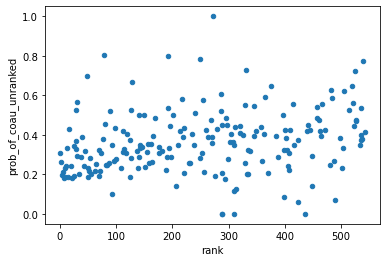

In [112]:
df_univ_rank.plot.scatter(x="rank",y="prob_of_coau_unranked")

In [113]:
# the probability of working with an institution that ranked top 50

top50rankedprobs = []

for univ in df_univ_rank.index:
    sum_coau_num = 0
    sum_top50ranked = 0
    for link in links_all:
        if univ in link:
            sum_coau_num += link[2]   # add on to coauthor number
            if univ == link[0]:
                try:
                    corank = int(df_univ_rank.loc[link[1],"rank"])
                except:
                    corank = 1000
            else:
                try:
                    corank = int(df_univ_rank.loc[link[0],"rank"])
                except:
                    corank = 1000
            # add if corank <= 50
            if corank <= 50:
                sum_top50ranked += link[2]

    # append to list
    try:
        top50rankedprobs.append(sum_top50ranked / sum_coau_num)
    except:
        top50rankedprobs.append(0)

df_univ_rank["prob_of_coau_top50ranked"] = top50rankedprobs
df_univ_rank.head()

,rank,crscore,prob_of_coau_unranked,prob_of_coau_top50ranked
name,,,,
University of Minnesota,164,118.295950,0.260369,0.235023
New York University,50,90.403344,0.234400,0.363200
London School of Economics,1,96.413699,0.307400,0.378558
McMaster University,449,233.791667,0.294118,0.073529
Duke University,84,92.403131,0.247423,0.281296


<AxesSubplot:xlabel='rank', ylabel='prob_of_coau_top50ranked'>

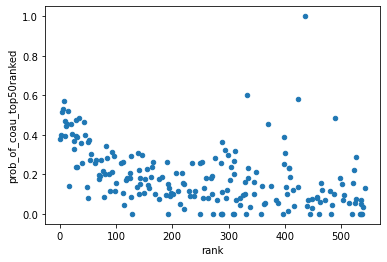

In [114]:
df_univ_rank.plot.scatter(x="rank",y="prob_of_coau_top50ranked")